In [7]:
%%time

import fastai
from fastai.vision.all import *
from pathlib import Path
import os

CPU times: user 337 µs, sys: 186 µs, total: 523 µs
Wall time: 531 µs


In [2]:
%%time
#! kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              237KB  2021-12-03 07:25:55          16881       1321  1.0              
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01          10211        733  0.9375           
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           4729        330  1.0              
dhruvildave/wikibooks-dataset                               Wikibooks Dataset             

In [3]:
%%time
#! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100%|█████████████████████████████████████▉| 2.29G/2.29G [01:06<00:00, 32.2MB/s]
100%|██████████████████████████████████████| 2.29G/2.29G [01:06<00:00, 37.0MB/s]
CPU times: user 2.17 s, sys: 518 ms, total: 2.69 s
Wall time: 1min 8s


In [4]:
%%time

#! unzip chest-xray-pneumonia.zip

Archive:  chest-xray-pneumonia.zip
  inflating: chest_xray/__MACOSX/._chest_xray  
  inflating: chest_xray/__MACOSX/chest_xray/._.DS_Store  
  inflating: chest_xray/__MACOSX/chest_xray/._test  
  inflating: chest_xray/__MACOSX/chest_xray/._train  
  inflating: chest_xray/__MACOSX/chest_xray/test/._.DS_Store  
  inflating: chest_xray/__MACOSX/chest_xray/test/._NORMAL  
  inflating: chest_xray/__MACOSX/chest_xray/test/._PNEUMONIA  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0001-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0003-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0005-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0006-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0007-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0009-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0010-0001.jpeg  
  inflating: chest_x

In [5]:
%%time
path = Path.cwd()/"subset_chest_xray/"

CPU times: user 130 µs, sys: 73 µs, total: 203 µs
Wall time: 139 µs


In [6]:
%%time
path.ls()

CPU times: user 1.06 ms, sys: 594 µs, total: 1.66 ms
Wall time: 1.22 ms


(#3) [Path('/home/subset_chest_xray/train'),Path('/home/subset_chest_xray/.ipynb_checkpoints'),Path('/home/subset_chest_xray/val')]

In [10]:
%%time
dblocks = DataBlock(blocks = (ImageBlock, CategoryBlock),
                    get_items = get_image_files,
                    get_y = parent_label,
                    splitter = GrandparentSplitter(train_name = "train", valid_name = "val"),
                    item_tfms = Resize(440),
                    batch_tfms = aug_transforms(size = 224, min_scale = 0.75)
                    )

CPU times: user 4.37 ms, sys: 2.99 ms, total: 7.36 ms
Wall time: 7.23 ms


In [14]:
%%time
dls = dblocks.dataloaders(path, bs = 64, device = "cuda")

CPU times: user 319 ms, sys: 49.9 ms, total: 369 ms
Wall time: 271 ms


CPU times: user 2.43 s, sys: 204 ms, total: 2.64 s
Wall time: 2.4 s


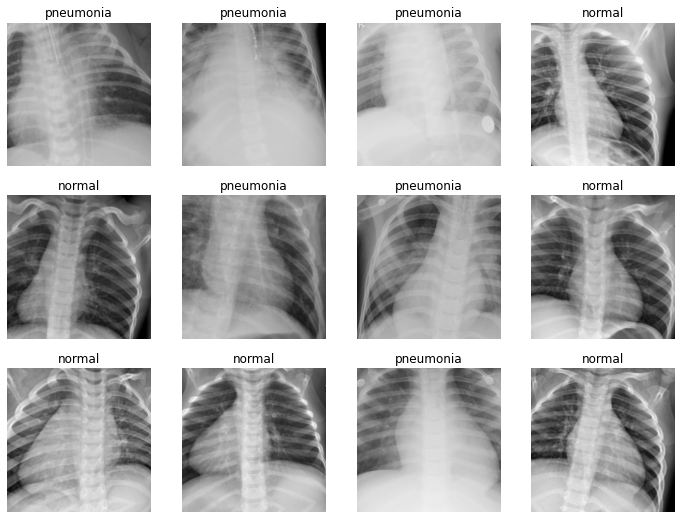

In [15]:
%%time
dls.show_batch(max_n = 12)

CPU times: user 11.5 s, sys: 2.67 s, total: 14.2 s
Wall time: 44.2 s


/opt/conda/lib/python3.8/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=0.001737800776027143)

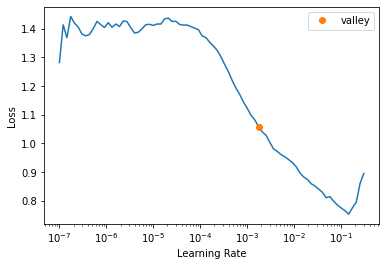

In [18]:
%%time

## baseline model

learn = cnn_learner(dls, resnet34 , metrics = accuracy)

learn.lr_find()

In [19]:
%%time

learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.425421,1.225412,0.784375,00:22
1,0.298734,0.448528,0.865625,00:22
2,0.242516,0.783424,0.823438,00:23
3,0.182668,0.293145,0.889063,00:22
4,0.158898,0.406635,0.892187,00:23
5,0.147289,0.323111,0.903125,00:22
6,0.120105,0.320626,0.918750,00:22
7,0.096772,0.286211,0.915625,00:22
8,0.075070,0.257282,0.928125,00:22
9,0.067577,0.255920,0.923437,00:22


CPU times: user 54.1 s, sys: 14 s, total: 1min 8s
Wall time: 3min 47s


CPU times: user 31.3 ms, sys: 21 ms, total: 52.3 ms
Wall time: 43.3 ms


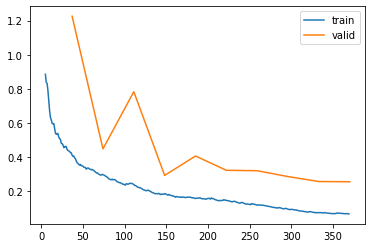

In [20]:
%%time

learn.recorder.plot_loss()

In [21]:
%%time

## model2 - here we will also unfreeze the earlier layers to improve the accuracy

CPU times: user 6 µs, sys: 2 µs, total: 8 µs
Wall time: 16.2 µs


In [22]:
%%time
learn = cnn_learner(dls, resnet34, metrics = accuracy)

learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.436778,0.796136,0.840625,00:22
1,0.329144,0.858123,0.821875,00:24
2,0.250530,0.363138,0.860937,00:22
3,0.196587,0.557198,0.857813,00:22
4,0.162721,0.271406,0.914062,00:22
5,0.139655,0.241129,0.932813,00:22
6,0.114273,0.208367,0.943750,00:23
7,0.097064,0.217911,0.937500,00:23
8,0.076584,0.231308,0.939062,00:22
9,0.070184,0.224003,0.934375,00:22


CPU times: user 55.1 s, sys: 14 s, total: 1min 9s
Wall time: 3min 49s


CPU times: user 8.67 s, sys: 5.23 s, total: 13.9 s
Wall time: 34 s


SuggestedLRs(valley=3.630780702224001e-05)

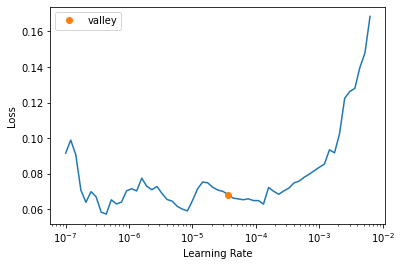

In [23]:
%%time

learn.unfreeze()

learn.lr_find()

In [24]:
%%time

learn.fit_one_cycle(5, 5e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.121948,4.665084,0.598437,00:23
1,0.149451,0.287329,0.903125,00:22
2,0.118527,0.219407,0.928125,00:23
3,0.093759,0.222886,0.923437,00:23
4,0.077202,0.200410,0.939062,00:23


CPU times: user 25.8 s, sys: 13.9 s, total: 39.8 s
Wall time: 1min 56s


CPU times: user 37.6 ms, sys: 4.36 ms, total: 42 ms
Wall time: 36.3 ms


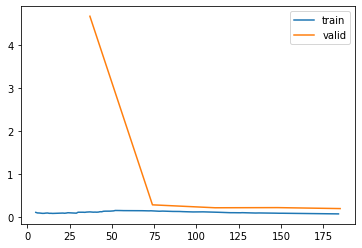

In [26]:
%%time

learn.recorder.plot_loss()

In [25]:
%%time

## model 3 - trying out progressive resizing 

CPU times: user 7 µs, sys: 2 µs, total: 9 µs
Wall time: 16.2 µs


In [27]:
%%time

def get_dls(size, bs):
    dblocks = DataBlock(blocks = (ImageBlock, CategoryBlock),
                        get_items = get_image_files, 
                        get_y = parent_label,
                        splitter = GrandparentSplitter(train_name = "train", valid_name = "val"),
                        item_tfms = Resize(440),
                        batch_tfms = aug_transforms(size = size, min_scale = 0.75))
    
    return dblocks.dataloaders(path, bs = bs, device = "cuda")

CPU times: user 12 µs, sys: 0 ns, total: 12 µs
Wall time: 19.6 µs


In [28]:
%%time

dls = get_dls(128,128)

CPU times: user 487 ms, sys: 49.5 ms, total: 537 ms
Wall time: 438 ms


In [29]:
%%time
learn = cnn_learner(dls, resnet34, metrics = accuracy)

learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.520764,1.018608,0.853125,00:25
1,0.397887,0.856561,0.834375,00:24
2,0.294291,0.420421,0.862500,00:25
3,0.230527,0.452173,0.876562,00:25
4,0.187175,0.296757,0.917188,00:25
5,0.160519,0.294321,0.917188,00:25
6,0.131613,0.263269,0.925000,00:25
7,0.118129,0.271559,0.928125,00:25
8,0.099644,0.241833,0.928125,00:25
9,0.087505,0.241204,0.925000,00:24


CPU times: user 29.4 s, sys: 11.4 s, total: 40.7 s
Wall time: 4min 11s


In [30]:
%%time

learn.dls = get_dls(224, 64)

CPU times: user 446 ms, sys: 22.4 ms, total: 468 ms
Wall time: 412 ms


In [31]:
%%time

learn.fine_tune(6, 3e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.232316,1.542252,0.864062,00:22


epoch,train_loss,valid_loss,accuracy,time
0,0.263695,1.850359,0.753125,00:23
1,0.209609,0.900073,0.887500,00:23
2,0.167174,0.667463,0.787500,00:23
3,0.147239,0.298691,0.926562,00:22
4,0.112435,0.290211,0.931250,00:22
5,0.093940,0.245406,0.934375,00:23


CPU times: user 37.9 s, sys: 19.9 s, total: 57.8 s
Wall time: 2min 41s


CPU times: user 32.4 ms, sys: 12.2 ms, total: 44.6 ms
Wall time: 38.3 ms


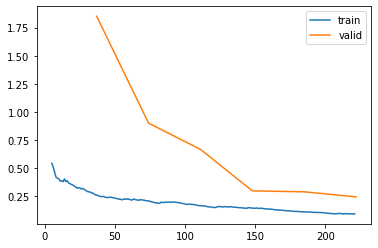

In [32]:
%%time

learn.recorder.plot_loss()

In [33]:
%%time

interp = ClassificationInterpretation.from_learner(learn)

CPU times: user 1.14 s, sys: 1.06 s, total: 2.2 s
Wall time: 6.39 s


CPU times: user 32.7 ms, sys: 29.7 ms, total: 62.4 ms
Wall time: 47.3 ms


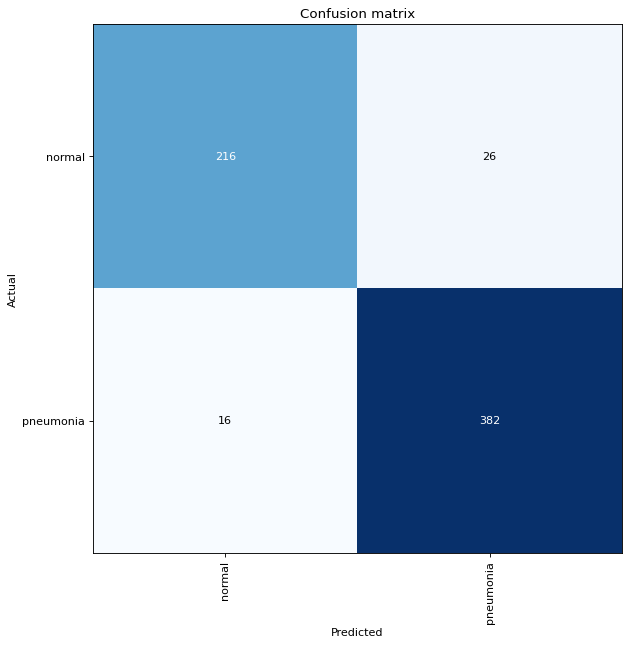

In [35]:
%%time

interp.plot_confusion_matrix(dpi = 80, figsize = (8,8))